## Background

The national discourse surrounding law enforcement has intensified in recent years, prompting a renewed exploration of alternative approaches to public safety.  The Cahoots model, a mobile crisis intervention program implemented in Eugene, Oregon, has emerged as a focal point in this conversation, attracting considerable attention as a potential alternative to certain facets of traditional policing. However, the degree to which Cahoots can effectively divert calls from law enforcement remains somewhat in dispute.

Various media outlets have reported that Cahoots diverts 17-20% of 911 calls for service (CFS) **(1)**, suggesting a significant reduction in police workload.  In contrast, the Eugene Police Department (EPD) asserts a more conservative estimate of 3-8%. **(2)**

The present research seeks to reconcile these divergent claims through an analysis that replicates the EPD's methodology, evaluates their underlying assumptions, and derives a data-driven conception of the diversion rate.  The research question central to this project is:

> **RQ 10:** "What proportion of calls are diverted from police to Cahoots response? How has that proportion changed over time?"

Cahoots provides services that the police do not, and police have many duties that do not overlap with the mission of Cahoots. Simply looking at the total proportion of calls does not tell the full story. By examining the diversion rate we can further ascertain the viability of the Cahoots model to replace certain types of police interaction. 


## Data

The data we will be using comes two sources. The first is computer aided dispatch (CAD) records from 2016-2021 for the Eugene area. This was obtained via public records request. 

Our second source of data will be the 2021 response paper published by the EPD. Since the EPD paper is not a traditional dataset, we will cover it in depth in the replication results section. This is because the data extraction, assumptions, and derived formulas are heavily intertwined with the results and will not be meaningful without proper context. The following section covers all traditional datasets. 

### CAD DATA

- **Source:**  Obtained through a public records request from the City of Eugene Police Department.
- **Observations:** Individual calls for service recorded by the CAD system.
- **Variables:** Call creation time, incident type, responding unit, disposition, zip code, IncidentNumber, Call_First_Dispatched_Time, Call_First_On_Scene, Call_Cleared,	IsPrimary, PrimaryUnitCallSign, RespondingUnitCallSign
- **Strengths:**  Comprehensive record of calls, allows for analysis of response patterns over time.
- **Limitations:**  
   - This dataset is quite messy and does not have a single identifier for Cahoots. Instead, it provides the exact unit call sign dispatched for each call, of which there are hundreds. Based on our findings I believe we have identified the vast majority of Cahoots call signs, but it is always possible that some were missed. In general, Cahoots call signs are of the "J" Category or follow some abbreviated form of cahoots like "CAHOT." For a list of all currently known call signs, see `date_prep.ipynb`
   - The call types are extraordinarily granular, with over 200 possible categories, some of which have had 4 total calls in 5 years. 
   - The are many data entry errors. For example there is a call type called "ACCIDENTALLY CHOSE NEW EVENT." This means there is likely no way to remove calls once created. Our analysis mitigates this issue by focusing mostly on dispatched calls. Call numbers that do not have specific evidence of resulting activity should be treating more skeptically.
   - The EPD neglected to provide all of the same features they seemed to have access to in their 2021 analysis. 

Here is a general idea of what the data looks like, I cannot show real raw data here as per the data use agreement: 

In [1]:
import pandas as pd
import numpy as np
data = {
    "IncNum": [
        "21000001", "21000002", "21000003", 
        "21000004", "21000005"
    ],
    "Call_Created": [
        "2021-01-01 00:00:58", "2021-01-02 14:15:23", "2021-01-03 09:30:45", 
        "2021-01-04 18:45:12", "2021-01-05 11:22:33"
    ],
    "Dispatched": [
        "2021-01-01 00:22:41", "2021-01-02 14:25:11", "2021-01-03 09:45:00", 
        "2021-01-04 18:50:30", "2021-01-05 11:30:45"
    ],
    "First_On_Scene": [
        pd.NaT, "2021-01-02 14:30:00", "2021-01-03 09:50:00", 
        pd.NaT, "2021-01-05 11:40:00"
    ],
    "Call_Cleared": [
        "2021-01-01 00:22:47", "2021-01-02 15:00:00", "2021-01-03 10:15:00", 
        "2021-01-04 19:00:00", "2021-01-05 12:00:00"
    ],

    "IsPrime": [1, 1, 1, 1, 1],
    
    "CallSign": ["CAHOOTS", "6E32", "6E33", "6E34", "CAHOOTS"],
    
    "type": ["Welfare", "Fight", "Dispute", "Trespass", "Transport" ],
    
    "Cahoots": [
        1, 0, 1, 0, 1
    ]
}

df = pd.DataFrame(data)
df

,IncNum,Call_Created,Dispatched,First_On_Scene,Call_Cleared,IsPrime,CallSign,type,Cahoots
0,21000001,2021-01-01 00:00:58,2021-01-01 00:22:41,NaT,2021-01-01 00:22:47,1,CAHOOTS,Welfare,1
1,21000002,2021-01-02 14:15:23,2021-01-02 14:25:11,2021-01-02 14:30:00,2021-01-02 15:00:00,1,6E32,Fight,0
2,21000003,2021-01-03 09:30:45,2021-01-03 09:45:00,2021-01-03 09:50:00,2021-01-03 10:15:00,1,6E33,Dispute,1
3,21000004,2021-01-04 18:45:12,2021-01-04 18:50:30,NaT,2021-01-04 19:00:00,1,6E34,Trespass,0
4,21000005,2021-01-05 11:22:33,2021-01-05 11:30:45,2021-01-05 11:40:00,2021-01-05 12:00:00,1,CAHOOTS,Transport,1


While this data has a single source, this project creates two separate datasets based on the CAD data. These datasets serve two separate purposes:

**Dataset 1: Replication Data** (data_prep.ipynb)

The purpose of this dataset is to approximate the data used in the 2021 EPD paper as closely as possible. Based on the replications of the EPD diversion methodology, we will use this dataset to rerun our calculations under different assumptions. It is important to note that since EPD has access to more specific features, the numbers cannot match 1:1 for every calculation. For example, the EPD seems to possess a straightforward way of pulling only Cahoots calls while we have to clean the call signs manually. I have made a separate public records request to address this, but for now, we will work with the tools available. 

**Creation of Dataset:**

1.  **Import and Load:**
    *   Import necessary libraries.
    *   Load CAD data from `data/call_data_from_CAD.csv`.

2.  **Preprocess and Clean:**
    *   Convert call times to datetime objects and add a year column.
    *   Standardize Cahoots identifiers in call sign columns.
    *   Create a binary column `Cahoots_Related` indicating Cahoots involvement.
    *   Drop irrelevant columns.
    *   Sort data by `Call_Created_Time`.

3.  **Create Subset and Save:**
    *   Create a 2021-only dataset for replication purposes.
    *   Save both datasets to `data/cleaned_data/`. 

**Dataset 2: Diversions Data** (data_prep.ipynb)

The purpose of this dataset is to calculate a novel conception of diversion rates based on call types of overlapping mandate. Since the EPD calculations do not remove any call types that fall outside of the Cahoots mission, we explore the results of only considering areas of substantial overlap. 

**How this dataset was made:**

1.  **Load and Prepare:**
    *   Load relevant columns from `data/call_data_from_CAD.csv`.
    *   Convert datetime objects.
    *   Filter for the years 2017-2021.
    *   Remove Disregards, duplicates, referrals, and cancellations.

2.  **Identify Exclusive Types:**
    *   Identify incident types and dispositions handled exclusively by either Cahoots or police.

3.  **Filter for Shared Types:**
    *   Filter the cleaned CAD data to include only shared incident and disposition types.

4.  **Calculate Proportions:**
    *   Calculate the proportion of Cahoots and police involvement for each incident type.

5.  **Identify "Substantial" Incident Types (Composite Score):**
    *   **Harmonic Mean of Proportions:** Calculate the harmonic mean to emphasize types with greater potential for diversion.
    *   **Scale Call Counts:** Apply a log transform to Cahoots and police call counts to prevent high-volume types from dominating.
    *   **Combine:** Multiply the harmonic mean by the sum of scaled call counts to obtain the composite score.
    *   **Normalize:** Apply Z-score normalization to the composite scores.
    *   **Threshold:** Incident types with a normalized score \> 1.5 are considered "substantial."

6.  **Filter and Save:**
    *   Create a filtered CAD dataset containing only substantial incident types.
    *   Save the filtered data to `"data/cleaned_data/cleaned_CAD_diversions.csv"`.


## Methods

**Replicating the EPD Paper**

This section replicates and critically evaluates the diversion rate calculation methodology presented in the 2021 EPD report. We reproduce their data preparation and filtering criteria to reconstruct the incident type tables and seven diversion rates initially considered. 

While the EPD report emphasizes two specific estimates (3%-8%) **(2)**, denoted as diversion rates 3a and 3b, our replication includes all seven rates to assess the validity of our data filtering assumptions. We primarily focus on 3a and 3b since the EPD claims the other rates are flawed and that 3a and 3b are the most accurate estimates.

| Step                                             | Method                                          | Resources         | Input                          | Output                                                               |
|--------------------------------------------------|-------------------------------------------------|-------------------|--------------------------------|----------------------------------------------------------------------|
| Extract EPD numbers                              | Manually record numbers from EPD tables         | `Python`          | EPD paper                      | Variables with all needed numbers                                    |
| Derive diversion formulas                        | Follow and reverse engineer missing methods     | `Python`          | Raw Numbers                    | Formulas for each diversion rate                                     |
| Rerun EPD calculations                           | Recalculate rates using formulas                | `Python`          | Raw Numbers                    | Verified recalculated diversion rates                                |
| Run diversions methodology script           | Apply police methodology to dataset             | `Python`, `Pandas`| CAD DATA 2021, welfare_prop | Diversion rate results and datasets `datasets_and_results`           |
| Confirm results validity                         | Compare recalculated and script results         | `Python`, `Pandas`| `datasets_and_results`         | Difference in diversion rates, real data vs EPD paper                              |
| Recreate EPD paper figures                       | Generate figures 1-5 using data                 | `Python`, `Pandas`| `datasets_and_results`         | Figures 1-5 as in EPD paper, for comparison                          |



**The Natural Experiment**

The EPD asserts that 74% of "Check Welfare" calls are eligible for diversion by CAHOOTS, based on a 2019 analysis of 200 calls. However, this figure lacks methodological transparency and relies solely on the subjective opinions of an unspecified number of dispatchers. **(2)**

While we cannot definitively determine the impact of CAHOOTS' absence, we can analyze the program's expansion in 2017. Prior to the expansion, calls received between 5 am and 10 am fell under the EPD's jurisdiction and were therefore eligible for diversion by definition. If the 74% figure is accurate, we should observe a significant increase in dispatched calls for welfare checks and other Cahoots centric call types between 2016 and 2017, when CAHOOTS extended its service hours. **(4)**

Comparing the ratio of calls between 2016 and 2017 for each incident type offers a more objective basis for adjusting the estimated proportion of calls eligible for diversion. This data-driven approach minimizes reliance on subjective assessments and provides a clearer perspective on the true proportion of divertible calls. Future research could strengthen this analysis with access to data before 2016.


| Step                                         | Method                             | Resources                  | Input                               | Output                                   |
|----------------------------------------------|------------------------------------|----------------------------|-------------------------------------|------------------------------------------|
| Calculate welfare check proportions         | Use `calculate_prop` function      | `Python`, `Pandas`         | `data_2016`, `data_2017`, `incident`| Proportion of divertible checks          |
| Re-run methodology script                   | Recalculate using welfare changes  | `Python`, `Pandas`         | `cleaned_data`, `welfare_prop`      | Adjusted Diversion Rates                 |
| Calculate divertible calls                  | Use `calculate_prop` for all types | `Python`, `Pandas`         | `data_2016`, `data_2017`, `incidents`| Divertible proportion per call type      |
| Re-run with new proportions                 | Adjust rates with new proportions  | `Python`, `Pandas`         | `cleaned_data`, `incident_scalers`  | True Diversion Rate                      |
| Yearly diversions calculation               | Run methodology script per year    | `Python`, `Pandas`         | `CAD_data_cleaned`                  | Diversions by year                       |
| Plot yearly diversions                      | Create diversion rate chart        | `Python`, `Pandas`, `matplotlib` | `diversion_rates_by_year`, `rate_key`, `low_estimate_key` | Stacked barchart of yearly rates        |
| Hourly diversions plot                     | High estimate by hour              | `Python`, `Pandas`, `matplotlib` | `diversion data`                | Chart of diversions by hourly volume     |


**Diversions of Overlapping Mandate**

Our analysis thus far has centered on the overall diversion rate, providing a broad picture of how Cahoots impacts overall EPD call volume. However, this metric can be misleading as it includes incidents where Cahoots' involvement would be unexpected or inappropriate, such as armed robberies or traffic violations. While the EPD emphasizes that many Cahoots calls fall outside traditional police responsibilities, they overlook the converse – incidents solely within the police purview. 

This section takes a more refined approach by introducing the concept of the "Overlapping Mandate."
The Overlapping Mandate consists of incident types that both Cahoots and the police handle regularly. By isolating these calls and recalculating the diversion rate, we can better understand Cahoots' impact in areas where their services are a direct alternative to police intervention. This analysis provides a more accurate picture of Cahoots' effectiveness in fulfilling its intended role.

| Step                                         | Method                                                           | Resources             | Input                       | Output                                                                  |
|-----------------------------------------------|-----------------------------------------------------------------|-----------------------|----------------------------|--------------------------------------------------------------------------|
| Generate Tree Plots                        | Execute `tree.py` script           | `Python`, `Pandas`, `matplotlib`, `hashlib`, `squarify` | `data`, `top_n`, `labels`, `color_list`, `min label area` | Tree plot of incident types              |
| Load Diversions Data| Load data with "substantial" incident types based on composite scores. | `Python`, `pandas`              | Cleaned CAD Diversions dataset | Filtered dataset with incident types suitable for potential diversion.        |
| Yearly Proportions (Overlapping Calls)      | Group calls by year and agency, calculate and plot proportions.     | `Python`, `pandas`, `matplotlib` | Filtered CAD dataset         | Stacked bar chart of Diversion Rates of Overlapping Mandate |
| Top 5 Overlapping Incidents                | Identify the top 5 most "substantial" overlapping incident types.        | `Python`, `pandas`, `matplotlib` | Filtered CAD dataset         | Bar chart for each agency showing Diversion Rates by incident type|



## Results

### Part 1: Replication

The EPD analysis begins by examining three subsets of Cahoots' data:

1.  **Cahoots Associations:** Any call where Cahoots has some involvement.
2.  **Cahoots Dispatched:** Calls where a Cahoots unit is sent out.
3.  **Cahoots Arrived:** Calls where a Cahoots unit arrives on scene.

These datasets are used to calculate what the EPD terms the "Gross Diversion Rates." The EPD claims that these metrics are not reliable, as they include calls that typically fall outside the scope of traditional police work.

**Gross Diversion Rates**

| Rate | Formula | Description |
|---|---|---|
| **Diversion Rate 1a** |  $\frac{\text{CAHOOTS Associations}}{\text{Total Calls}}$  | This rate represents all instances where CAHOOTS was associated with a call, regardless of dispatch or arrival status. |
| **Diversion Rate 1b** | $\frac{\text{CAHOOTS Dispatched}}{\text{Total Calls}}$ | This rate considers calls where CAHOOTS was dispatched. |
| **Diversion Rate 1c** | $\frac{\text{CAHOOTS Only Arrived}}{\text{Total Calls}}$  | This rate considers all calls where CAHOOTS alone arrived at the scene. |



####  The Curious Case of Missing Call Types and Shifting Denominators

The EPD report goes on to present 4 more diversion rate calculations, each with its own set of assumptions and inconsistencies. **(2)**
<br>


**Diversion Rates 2a and 2b: A Tale of Two Denominators**

The report claims the top 3 incident types handled by CAHOOTS – Assist Public, Check Welfare, and Transport – are not typical police calls. Based on this, diversion rates 2a and 2b are calculated by subtracting these call types from the total CAHOOTS call volume and assuming the remaining calls to be divertible (Remember this when we go into 3a and 3b)

* **Diversion Rate 2a:**  The report defines this as the ratio of (total arrived CAHOOTS calls minus the top 3 call types) to the total number of calls for service (CFS). However, it's unclear if the denominator also excludes the top 3 CAHOOTS call natures. 

The EPD report says the correct diversion rate here is 2%. Depending on how the denominator is calculated, the diversion rate fluctuates between 2.3% (without removing top 3 call types from the denominator) and 2.6% (with removal). This ambiguity raises concerns about the calculation's accuracy. Furthermore, comparing the subset of *arrived only* CAHOOTS calls to the total call volume, which includes calls that were never even dispatched, is methodologically flawed.

* **Diversion Rate 2b:** This calculation attempts to address the denominator issue but introduces further inconsistencies. The EPD paper says it is trying to measure the diversion rate for Dispatched only calls, excluding the top 3 Cahoots call types. However, the actual implementation takes a bit of detour.

>  "If we look only at dispatched calls for both agencies (68,427) and subtract out the removed CAHOOTS natures (11,667) we are left with 56,760 total dispatched CFS, of which 2,545 were handled by CAHOOTS, which would equate to ~4% divert rate of dispatched calls." **(2)**

As indicated by the report, the denominator is selected by taking the total dispatched calls and subtracting the top 3 Cahoots types. The problem is that the numerator uses the count of *arrived* CAHOOTS calls (excluding the top 3 Cahoots types), while the denominator considers total *dispatched* calls (adjusted for the top 3 arrived CAHOOTS types).

We know that *arrived* CAHOOTS calls are being used here because the report also states:

> "However, as discussed when examining call natures, the top 3 CAHOOTS CFS natures: Assist Public (5,058), Check Welfare (5,022), and Transport (1,587) are not traditionally law enforcement calls and would likely not be dispatched to police." **(2)**

These values sum exactly to 11,667 and can be found in data table 5 of the EPD report which describes Arrived only Cahoots Calls. We can get the exact numerator they describe by subtracting 11,667 from total calls in table 5.**(2)**

For some reason, we are using arrived only calls in the numerator and using total dispatched calls in the denominator, while adjusting the denominator based on arrived only calls. This diversion rate does not have the benefit of ambiguity seen in diversion rate 2a since it describes the exact numbers used to reach the denominator. This mixing of dispatched and arrived data without justification renders the resulting 4% diversion rate meaningless.
<br>
<br>

**Diversion Rates 3a and 3b: The Vanishing Call Types**  

These rates are the final EPD assessment of the true diversion rate. They assume welfare checks to be the only potentially divertible calls, and rely on a 2019 analysis where an unspecified number of dispatchers categorized 74% of a 200-call sample as suitable for CAHOOTS. **(Source)

 Both 3a and 3b disregard all other call types, many of which were deemed as the only divertible calls in the 2a/2b calculations. The basis of 2a/2b is that Check welfare, Transport, and Public Assists are not typically police calls so they should be excluded. However, all other call types were assumed to eligible for diversion in 2a/2b. 3a/3b then makes the argument that entirely excluding welfare calls is not fair, so they apply their 74% adjustment to the welfare check category. Yet, somewhere along the way we lost track of all those other divertible call types. This arbitrary exclusion lacks justification and contradicts the report's previous logic. 
 
 When you consider the other call types to be divertible, you get a range of 5% - 11%. This should have been the final range presented by the paper without clear justification to exclude the other call types. 


* **Diversion Rate 3a:** Calculates the diversion rate as the percentage of dispatched welfare checks (assumed 74% divertible) out of the total CFS. It shares the methodological flaw of mixing total and dispatched calls seen in 2a.


* **Diversion Rate 3b:** Similar to 2b, this compares dispatched welfare checks to total dispatched calls, but without the same mixing of arrival data. This is good news for this estimate but makes the thought process behind 2b rather mysterious. 
<br>
<br>

**Data Discrepancies**

The paper reports the number of dispatched welfare checks as 5,546 but data table 2 of the paper reports the number as 6,003. 5,546 shows up nowhere else in the paper so this seems to be based on outdated data. For the first calculations, I will assume the explicitly stated 5,546 value. (More on this later)

<br>

**Adjusted Diversion Rates**

| Rate | Formula | Description |
|---|---|---|
| **Diversion Rate 2a** | $\frac{\text{CAHOOTS Only Arrived} - (\text{top 3 arrived Cahoots incidents})}{\text{Total Calls}}$  | Removes the total count of the 3 most common call types handled by Cahoots from the numerator. |
| **Diversion Rate 2b** | $\frac{\text{CAHOOTS Only Arrived} - (\text{top 3 arrived Cahoots incidents})}{\text{(Dispatched EPD and Cahoots) - (top 3 arrived Cahoots incidents)}}$  | Similar to 2a, but only adjusts the denominator based on dispatched/arrived |
| **Diversion Rate 3a (Low)** | $\frac{\text{(Dispatched Cahoots Welfare Calls) * 0.74}}{\text{Total Calls}}$ | Assumes that Welfare check is the only diverted call type and that 0.74 are diversions. |
| **Diversion Rate 3b (High)** | $\frac{\text{(Dispatched Cahoots Welfare Calls) * 0.74}}{\text{(All Dispatched calls) - (Dispatched Cahoots calls - adjusted welfare checks)}}$  | Similar to Diversion Rate 6 (Low), but calculated using the adjusted total for dispatched calls. |

**Replication using extracted data**

In [2]:
#| code-fold: show

# --- CAHOOTS Data ---
cahoots_total_assoc = 22055 

# dispatch
cahoots_dispatches = 18106
cahoots_dispatches_check_welfare = 5546 # 6003 is the value in the data table 
cahoots_dispatches_transport = 1803 
cahoots_dispatches_assist = 5788

# arrival
cahoots_arrivals_solo = 14212
cahoots_arrivals_assist_public = 5058
cahoots_arrivals_check_welfare = 5022
cahoots_arrivals_transport = 1587

# --- EPD Data ---
epd_total_calls = 109854 
epd_dispatches_and_cahoots = 68427

# Calculated EPD dispatch count (excluding cases with CAHOOTS)
epd_dispatches_solo = epd_dispatches_and_cahoots - cahoots_dispatches  

# 1. Gross Divert Rates 
diversion_rate_associations = (cahoots_total_assoc / epd_total_calls) * 100
diversion_rate_dispatches = (cahoots_dispatches / epd_total_calls) * 100
diversion_rate_cahoots_only_arrivals = (cahoots_arrivals_solo / epd_total_calls) * 100

# 2. Diversion Rate (Removing Top 3 Cahoots Calls)
diversion_rate_removing_centric_calls =  ((cahoots_arrivals_solo - cahoots_arrivals_assist_public - cahoots_arrivals_check_welfare - cahoots_arrivals_transport) / epd_total_calls) * 100

diversion_rate_removing_centric_calls_dispatch =  ((cahoots_arrivals_solo - cahoots_arrivals_assist_public - cahoots_arrivals_check_welfare - cahoots_arrivals_transport) / 
                                                   (epd_dispatches_and_cahoots - cahoots_arrivals_transport - cahoots_arrivals_check_welfare - cahoots_arrivals_assist_public)) * 100


# Diversion Rate welfare check adjusted (Low)
CHECK_WELFARE_EPD_PROBABILITY = 0.74 
estimated_epd_check_welfare = CHECK_WELFARE_EPD_PROBABILITY * cahoots_dispatches_check_welfare

diversion_rate_adjusted_all_calls = (estimated_epd_check_welfare / epd_total_calls) * 100

# Diversion Rate welfare check adjusted (High)
diversion_rate_adjusted_dispatched_calls_high = (estimated_epd_check_welfare / (epd_dispatches_and_cahoots - (cahoots_dispatches - estimated_epd_check_welfare))* 100 )


In [3]:
# --- Output ---
result_og = {
        "1a. Diversion Rate (Associations)": diversion_rate_associations,
        "1b. Diversion Rate (Dispatches)": diversion_rate_dispatches,
        "1c. Diversion Rate (CAHOOTS Only Arrivals)": diversion_rate_cahoots_only_arrivals,
        "2a. Diversion Rate (Removing CAHOOTS-Centric Calls)": diversion_rate_removing_centric_calls,
        "2b. Diversion Rate (Removing CAHOOTS-Centric Calls, Dispatch only)": diversion_rate_removing_centric_calls_dispatch,
        "3a. Diversion Rate (Adjusted for Check Welfare - All Calls)": diversion_rate_adjusted_all_calls,
        "3b. Diversion Rate (Adjusted for Check Welfare - Dispatched Calls)": diversion_rate_adjusted_dispatched_calls_high
    }
result_og

{'1a. Diversion Rate (Associations)': 20.076647186265404,
 '1b. Diversion Rate (Dispatches)': 16.48187594443534,
 '1c. Diversion Rate (CAHOOTS Only Arrivals)': 12.937171154441348,
 '2a. Diversion Rate (Removing CAHOOTS-Centric Calls)': 2.316711271323757,
 '2b. Diversion Rate (Removing CAHOOTS-Centric Calls, Dispatch only)': 4.4837914023960534,
 '3a. Diversion Rate (Adjusted for Check Welfare - All Calls)': 3.7359040180603347,
 '3b. Diversion Rate (Adjusted for Check Welfare - Dispatched Calls)': 7.540720227307136}

Despite the methodological errors in the EPD diversion rate calculations, we will still attempt to replicate them exactly. To do this on the real dataset, we will be using `police_diversion_methodology.py`. This gives us access to a function I wrote called `run_police_diversions` that applies the same formulas above to our data. It also allows for us the to change the assumed divertible proportions for various call types. 

In [4]:
import os
os.chdir('../')

In [5]:
from scripts.police_diversion_methodology import run_police_diversions
import pandas as pd

file_path = 'Data/cleaned_data/cleaned_CAD_data_2021_diversions.csv'
cleaned_data = pd.read_csv(file_path)

datetime_columns = ['Call_Created_Time', 'Call_First_Dispatched_Time', 'Call_First_On_Scene', 'Call_Cleared']
for col in datetime_columns:
    cleaned_data[col] = pd.to_datetime(cleaned_data[col], errors='coerce')
    
cleaned_data = cleaned_data.dropna(subset=['Call_Created_Time', 'Call_Source', 'InitialIncidentTypeDescription'])

**EPD Methodology Using the CAD Data**

In [6]:
datasets_and_results = run_police_diversions(cleaned_data, 0.74)
datasets_and_results['results']

{'1a. Diversion Rate (Associations)': 20.755246527966392,
 '1b. Diversion Rate (Dispatches)': 16.41045140963659,
 '1c. Diversion Rate (CAHOOTS Only Arrivals)': 13.431835877378816,
 '2a. Diversion Rate (Removing CAHOOTS-Centric Calls)': 2.580259655603238,
 '2b. Diversion Rate (Removing CAHOOTS-Centric Calls, Dispatch only)': 5.02929342838992,
 '3a. Diversion Rate (Adjusted for Check Welfare - All Calls)': 4.024462672243649,
 '3b. Diversion Rate (Adjusted for Check Welfare - Dispatched Calls)': 8.086088525349998}

**Difference in results, EPD paper vs CAD DATA calculation**

In [7]:
difference = {key: round(datasets_and_results['results'].get(key, 0) - result_og[key], 2) for key in result_og}
difference

{'1a. Diversion Rate (Associations)': 0.68,
 '1b. Diversion Rate (Dispatches)': -0.07,
 '1c. Diversion Rate (CAHOOTS Only Arrivals)': 0.49,
 '2a. Diversion Rate (Removing CAHOOTS-Centric Calls)': 0.26,
 '2b. Diversion Rate (Removing CAHOOTS-Centric Calls, Dispatch only)': 0.55,
 '3a. Diversion Rate (Adjusted for Check Welfare - All Calls)': 0.29,
 '3b. Diversion Rate (Adjusted for Check Welfare - Dispatched Calls)': 0.55}

#### Analyzing Discrepancies

Comparing our calculated results with those reported in the EPD paper, we observe differences within a single percentage point. However, discrepancies in Diversion Rates 3a and 3b, crucial for accurate assessment, warrant closer examination.

Initially, the differences for 3a and 3b appear on the larger side compared to other values. However, a curious finding emerges when considering the conflicting dispatched welfare check figures. Changing the value from the paper's stated 5,546 to the 6,003 found in its data table virtually eliminates the discrepancy. Our calculation for 3a then rises from 7.5% to 8.1%, closely matching the paper's reported 8%. This suggests the 5,546 figure was outdated, and the actual high-end estimate calculation used 6,003.

The low-end estimate presents a challenge. Applying the 6,003 value increases it from 3.8% to 4%, leaving a slight gap. This might indicate the high-end estimate was calculated later with additional data.  It's possible that 6,003 was used for the high-end and 5,546 for the low-end.

With discrepancies for 3a and 3b now within 0.03 percentage points, we can confidently conclude that our function successfully reproduces our derived understanding of the EPD's methodology. While small differences exist in associations and arrivals, they don't affect the final range presented by the EPD. 

In [8]:
datasets_and_results['cahoots_dispatched']["InitialIncidentTypeDescription"].value_counts().reset_index().head(1)

,InitialIncidentTypeDescription,count
0,CHECK WELFARE,6007


**Re-run the replication numbers with the 6,003 from data table 2 of the EPD paper**

In [9]:
# Diversion Rate welfare check adjusted (Low)
CHECK_WELFARE_EPD_PROBABILITY = 0.74 
estimated_epd_check_welfare = CHECK_WELFARE_EPD_PROBABILITY * 6003
diversion_rate_adjusted_all_calls = (estimated_epd_check_welfare / epd_total_calls) * 100

# Diversion Rate welfare check adjusted (High)
diversion_rate_adjusted_dispatched_calls_high = (estimated_epd_check_welfare / (epd_dispatches_and_cahoots - (cahoots_dispatches - estimated_epd_check_welfare))* 100 )

result_og = {
        "1a. Diversion Rate (Associations)": diversion_rate_associations,
        "1b. Diversion Rate (Dispatches)": diversion_rate_dispatches,
        "1c. Diversion Rate (CAHOOTS Only Arrivals)": diversion_rate_cahoots_only_arrivals,
        "2a. Diversion Rate (Removing CAHOOTS-Centric Calls)": diversion_rate_removing_centric_calls,
        "2b. Diversion Rate (Removing CAHOOTS-Centric Calls, Dispatch only)": diversion_rate_removing_centric_calls_dispatch,
        "3a. Diversion Rate (Adjusted for Check Welfare - All Calls)": diversion_rate_adjusted_all_calls,
        "3b. Diversion Rate (Adjusted for Check Welfare - Dispatched Calls)": diversion_rate_adjusted_dispatched_calls_high
    }
result_og

{'1a. Diversion Rate (Associations)': 20.076647186265404,
 '1b. Diversion Rate (Dispatches)': 16.48187594443534,
 '1c. Diversion Rate (CAHOOTS Only Arrivals)': 12.937171154441348,
 '2a. Diversion Rate (Removing CAHOOTS-Centric Calls)': 2.316711271323757,
 '2b. Diversion Rate (Removing CAHOOTS-Centric Calls, Dispatch only)': 4.4837914023960534,
 '3a. Diversion Rate (Adjusted for Check Welfare - All Calls)': 4.043748975913485,
 '3b. Diversion Rate (Adjusted for Check Welfare - Dispatched Calls)': 8.111685178482931}

In [10]:
difference = {key: round(datasets_and_results['results'].get(key, 0) - result_og[key], 2) for key in result_og}
difference

{'1a. Diversion Rate (Associations)': 0.68,
 '1b. Diversion Rate (Dispatches)': -0.07,
 '1c. Diversion Rate (CAHOOTS Only Arrivals)': 0.49,
 '2a. Diversion Rate (Removing CAHOOTS-Centric Calls)': 0.26,
 '2b. Diversion Rate (Removing CAHOOTS-Centric Calls, Dispatch only)': 0.55,
 '3a. Diversion Rate (Adjusted for Check Welfare - All Calls)': -0.02,
 '3b. Diversion Rate (Adjusted for Check Welfare - Dispatched Calls)': -0.03}

#### Replicated Data Tables from the EPD Paper

For easy data comparison, we replicate the data tables from the EPD paper using the CAD data. Each table has the same label as seen in the paper. Fig 3, 6, and 7 are not included as they are not used for calculating any of the diversion rates. 

In [11]:
fig = 0
for i in list(datasets_and_results.keys())[:-1]:
    fig += 1
    if fig == 3:  # Check if figure number is 3
        fig += 1  # Skip figure number 3 by incrementing again

    # Create a DataFrame from the value counts
    count_series = datasets_and_results[i]['InitialIncidentTypeDescription'].value_counts()
    top_10 = count_series.head(10)
    other_count = count_series[10:].sum()
    
    # Create DataFrame for top 10
    df = pd.DataFrame(top_10).reset_index()
    df.columns = ['Incident Type', 'Count']
    
    # Create 'Other' row
    other_row = pd.DataFrame([{'Incident Type': 'Other', 'Count': other_count}])
    
    # Concatenate the top 10 DataFrame with the 'Other' row
    df = pd.concat([df, other_row], ignore_index=True)
    
    # Calculate the percentage of total calls
    total_calls = count_series.sum()
    df['Percentage of Total Calls'] = ((df['Count'] / total_calls) * 100).round(2).astype(str) + '%'
    
    # Append a row for the total count
    total_row = pd.DataFrame([{'Incident Type': 'Total', 'Count': total_calls}])
    df = pd.concat([df, total_row], ignore_index=True)
    
    # Check if it is not the last key to display the DataFrame
    if i != list(datasets_and_results.keys())[-2]:
        print(f"Figure {fig}: {i}")
        display(df)


Figure 1: cahoots_associations


,Incident Type,Count,Percentage of Total Calls
0,CHECK WELFARE,7615,33.22%
1,ASSIST PUBLIC- POLICE,7330,31.97%
2,TRANSPORT,2352,10.26%
3,SUICIDAL SUBJECT,1935,8.44%
4,DISORDERLY SUBJECT,543,2.37%
5,TRAFFIC HAZARD,444,1.94%
6,DISPUTE,328,1.43%
7,INTOXICATED SUBJECT,284,1.24%
8,CRIMINAL TRESPASS,278,1.21%
9,ASSIST FIRE DEPARTMENT,240,1.05%


Figure 2: cahoots_dispatched


,Incident Type,Count,Percentage of Total Calls
0,CHECK WELFARE,6007,33.14%
1,ASSIST PUBLIC- POLICE,5792,31.95%
2,TRANSPORT,1808,9.97%
3,SUICIDAL SUBJECT,1571,8.67%
4,DISORDERLY SUBJECT,457,2.52%
5,TRAFFIC HAZARD,372,2.05%
6,DISPUTE,256,1.41%
7,CRIMINAL TRESPASS,231,1.27%
8,INTOXICATED SUBJECT,219,1.21%
9,FOUND SYRINGE,192,1.06%


Figure 4: cahoots_only_associations


,Incident Type,Count,Percentage of Total Calls
0,ASSIST PUBLIC- POLICE,5715,35.02%
1,CHECK WELFARE,5708,34.98%
2,TRANSPORT,1788,10.96%
3,SUICIDAL SUBJECT,1301,7.97%
4,TRAFFIC HAZARD,329,2.02%
5,DISORDERLY SUBJECT,240,1.47%
6,INTOXICATED SUBJECT,206,1.26%
7,FOUND SYRINGE,191,1.17%
8,ASSIST FIRE DEPARTMENT,178,1.09%
9,DISORIENTED SUBJECT,132,0.81%


Figure 5: cahoots_only_arrived


,Incident Type,Count,Percentage of Total Calls
0,CHECK WELFARE,5222,35.2%
1,ASSIST PUBLIC- POLICE,5158,34.77%
2,TRANSPORT,1606,10.83%
3,SUICIDAL SUBJECT,1210,8.16%
4,TRAFFIC HAZARD,307,2.07%
5,DISORDERLY SUBJECT,218,1.47%
6,INTOXICATED SUBJECT,187,1.26%
7,ASSIST FIRE DEPARTMENT,163,1.1%
8,FOUND SYRINGE,160,1.08%
9,DISORIENTED SUBJECT,124,0.84%


### Part 2: Running The Natural Experiment

Our analysis successfully replicates the EPD's methodology, achieving a high degree of accuracy for their reported 3%-8% diversion rate range. However, we haven't yet fully scrutinized the assumed 74% divertible proportion for welfare checks. 

Instead of taking this figure at face value, we can leverage a data-driven approach to estimate police call volume in CAHOOTS' absence. Recall that CAHOOTS expanded its service hours to include 5am - 10am on January 1, 2017. This period offers a natural experiment: all calls during these hours before 2017 were inherently divertible, as they were handled solely by police. **(4)**

If the EPD's assertion about a significant portion of welfare checks being non-divertible holds true, we should observe a substantial increase in total welfare checks during these hours from 2016 to 2017. 


In [12]:
from scripts.natural_exp import calculate_prop, create_diversion_rate_chart

CAD_data = pd.read_csv("data/cleaned_data/cleaned_CAD_data_diversions.csv")
CAD_data["Call_Created_Time"] = pd.to_datetime(CAD_data['Call_Created_Time'], errors='coerce')
CAD_data["year"] = CAD_data["Call_Created_Time"].dt.year
CAD_data["Call_First_Dispatched_Time"] = pd.to_datetime(CAD_data['Call_First_Dispatched_Time'], errors='coerce')
CAD_data = CAD_data[CAD_data['Call_Source'] != 'SELF'].copy()
CAD_data = CAD_data.dropna(subset=['Call_Created_Time', 'Call_Source', 'InitialIncidentTypeDescription'])

data_2016 = CAD_data[(CAD_data["Call_First_Dispatched_Time"].dt.year == 2016) & 
                         (CAD_data["Call_First_Dispatched_Time"].dt.hour >= 5) & 
                         (CAD_data["Call_First_Dispatched_Time"].dt.hour < 10)].copy()

data_2017 = CAD_data[(CAD_data["Call_First_Dispatched_Time"].dt.year == 2017) & 
                         (CAD_data["Call_First_Dispatched_Time"].dt.hour >= 5) & 
                         (CAD_data["Call_First_Dispatched_Time"].dt.hour < 10)].copy()

data_2016.dropna(subset=['Call_First_Dispatched_Time'], inplace=True)
data_2017.dropna(subset=['Call_First_Dispatched_Time'], inplace=True)

Filtering for the appropriate time periods we find 1310 welfare checks in 2016 and 1361 welfare checks in 2017, representing an increase of ~4%. Despite this modest increase, Cahoots went on to handle 49% of welfare calls during this time period in 2017. Applying our `calculate_prop` function we find an estimated ~96% of welfare checks to be eligible for diversion. 

In [13]:
welfare_prop = calculate_prop(data_2016, data_2017, ["CHECK WELFARE"])["CHECK WELFARE"]
welfare_prop

2016: {'CHECK WELFARE': 1310}
2017: {'CHECK WELFARE': 1361}


0.9625275532696547

Percent of Welfare Checks Handled by Cahoots 2017:

In [26]:
(data_2017[data_2017["Cahoots_related"] == 1]["InitialIncidentTypeDescription"].value_counts().to_list()[0] / data_2017["InitialIncidentTypeDescription"].value_counts().to_list()[1]) * 100

49.62762356127285

For the "Check Welfare" category, the minimal change in call volume from 2016 to 2017 during the 5 am - 10 am period suggests that most of these calls are indeed divertible. This implies that the EPD's 0.74 diversion rate for welfare checks is a significant underestimation.

If we adjust the diversion rate for welfare checks to 0.96 in our `run_police_diversions` function, while keeping all other factors constant (as in the EPD's calculations), the recalculated diversion rates become:

#### Welfare Adjusted Results

In [15]:
welfare_corrected_results = run_police_diversions(cleaned_data, welfare_prop, 0, 0)
welfare_corrected_results['results']

{'1a. Diversion Rate (Associations)': 20.755246527966392,
 '1b. Diversion Rate (Dispatches)': 16.41045140963659,
 '1c. Diversion Rate (CAHOOTS Only Arrivals)': 13.431835877378816,
 '2a. Diversion Rate (Removing CAHOOTS-Centric Calls)': 2.580259655603238,
 '2b. Diversion Rate (Removing CAHOOTS-Centric Calls, Dispatch only)': 5.02929342838992,
 '3a. Diversion Rate (Adjusted for Check Welfare - All Calls)': 5.234670552891535,
 '3b. Diversion Rate (Adjusted for Check Welfare - Dispatched Calls)': 10.268003855748532}

With no other adjustments, our diversion rate now sits between 5% and 10%. However, this still falls short of capturing the EPD's stated goal, as it assumes all call types besides welfare checks have zero diversion potential. In reality, welfare checks are far from the only divertable call type. To demonstrate this, we will now calculate the divertible proportions for 3 additional call types, using the same natural experiment performed on welfare checks: `calculate_prop` 

#### Divertible Proportion of Call Types

In [16]:
incidents = ["CHECK WELFARE", "TRANSPORT", "ASSIST PUBLIC- POLICE", "SUICIDAL SUBJECT"]
correct_props = calculate_prop(data_2016, data_2017, incidents)
correct_props

2016: {'CHECK WELFARE': 1310, 'SUICIDAL SUBJECT': 253, 'ASSIST PUBLIC- POLICE': 134, 'TRANSPORT': 87}
2017: {'CHECK WELFARE': 1361, 'TRANSPORT': 585, 'ASSIST PUBLIC- POLICE': 583, 'SUICIDAL SUBJECT': 323}


{'CHECK WELFARE': 0.9625275532696547,
 'SUICIDAL SUBJECT': 0.7832817337461301,
 'ASSIST PUBLIC- POLICE': 0.22984562607204118,
 'TRANSPORT': 0.14871794871794872}

We can see that welfare checks are indeed the most divertible call type, however, the others are far from 0. Let's now proportionally consider these missing call types in our diversion rate calculations, holding all else equal. Note that only diversion 3a and 3b should be changing with these adjustments as diverison rates (1-2) are not impacted by the proportional analysis used by the EPD. 

#### Call type Adjusted Diversion Rates

In [17]:
welfare_prop = correct_props["CHECK WELFARE"]
transport_prop = correct_props["TRANSPORT"]
assist_prop = correct_props["ASSIST PUBLIC- POLICE"]
suicide_prop = correct_props["SUICIDAL SUBJECT"]

top_3_corrected_results = run_police_diversions(cleaned_data, welfare_prop, transport_prop, assist_prop, suicide_prop)
top_3_corrected_results['results']

{'1a. Diversion Rate (Associations)': 20.755246527966392,
 '1b. Diversion Rate (Dispatches)': 16.41045140963659,
 '1c. Diversion Rate (CAHOOTS Only Arrivals)': 13.431835877378816,
 '2a. Diversion Rate (Removing CAHOOTS-Centric Calls)': 2.580259655603238,
 '2b. Diversion Rate (Removing CAHOOTS-Centric Calls, Dispatch only)': 5.02929342838992,
 '3a. Diversion Rate (Adjusted for Check Welfare - All Calls)': 7.797441952031886,
 '3b. Diversion Rate (Adjusted for Check Welfare - Dispatched Calls)': 14.562903478797923}

#### Temporal Diversion Analysis

With these adjustments, our estimated diversion rate range now sits between 8% and 15%. This revised range is noteworthy, as our low-end estimate now matches the EPD's original maximum estimate. This convergence strongly suggests that the proportion of divertible call types is considerably higher than initially claimed.

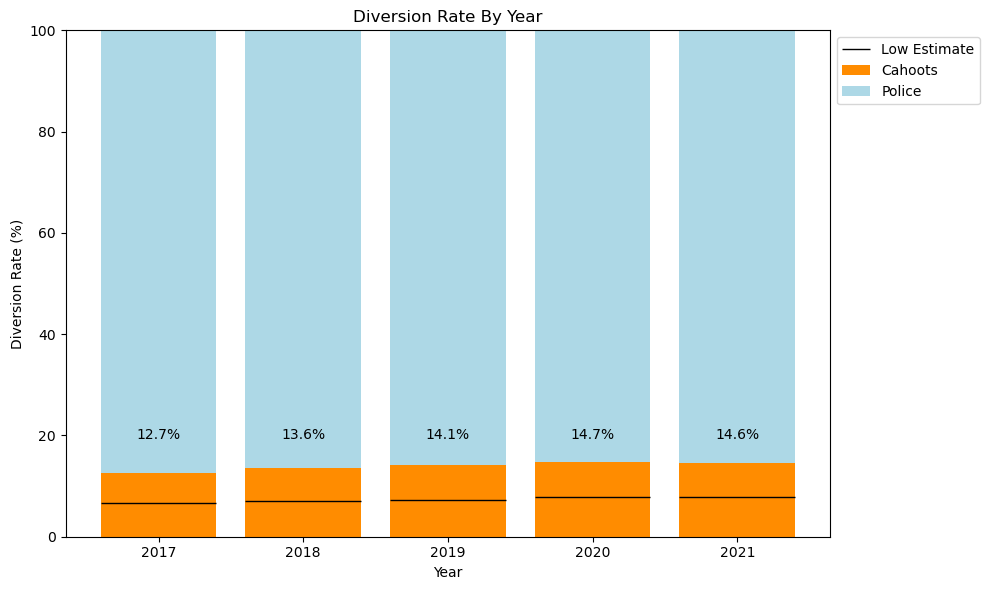

In [18]:
CAD_data_filter = CAD_data[(CAD_data["Call_Created_Time"].dt.year >= 2017) & (CAD_data["Call_Created_Time"].dt.year <= 2021)]

diversion_rates_by_year = {}
for year in range(2017, 2022):
    # Filter data for the current year
    yearly_data = CAD_data[CAD_data["Call_Created_Time"].dt.year == year]
    
    # Calculate diversion rates for the filtered yearly data
    yearly_rates = run_police_diversions(yearly_data, welfare_prop, transport_prop, assist_prop, suicide_prop)
    
    # Store the results in the dictionary
    diversion_rates_by_year[year] = yearly_rates['results']
    
create_diversion_rate_chart(
    diversion_rates_by_year,
    rate_key='3b. Diversion Rate (Adjusted for Check Welfare - Dispatched Calls)',
    low_estimate_key='3a. Diversion Rate (Adjusted for Check Welfare - All Calls)',
    title='Diversion Rate By Year',
    rate_label='Cahoots',
    low_estimate_label='Low Estimate' 
)

Examining the diversion rate breakdown by year shows that while the overall diversion rate has remained relatively stable since 2017, it has shown a slight, but consistent, upward trend. This suggests that Cahoots' services have gradually expanded to encompass a wider range of traditionally police-handled calls, while still predominantly focusing on their core mandate.

Future work could delve deeper into the specific call types that have contributed to the increase in diversion rates. This analysis could shed light on the changing nature of Cahoots and potential mission creep. 

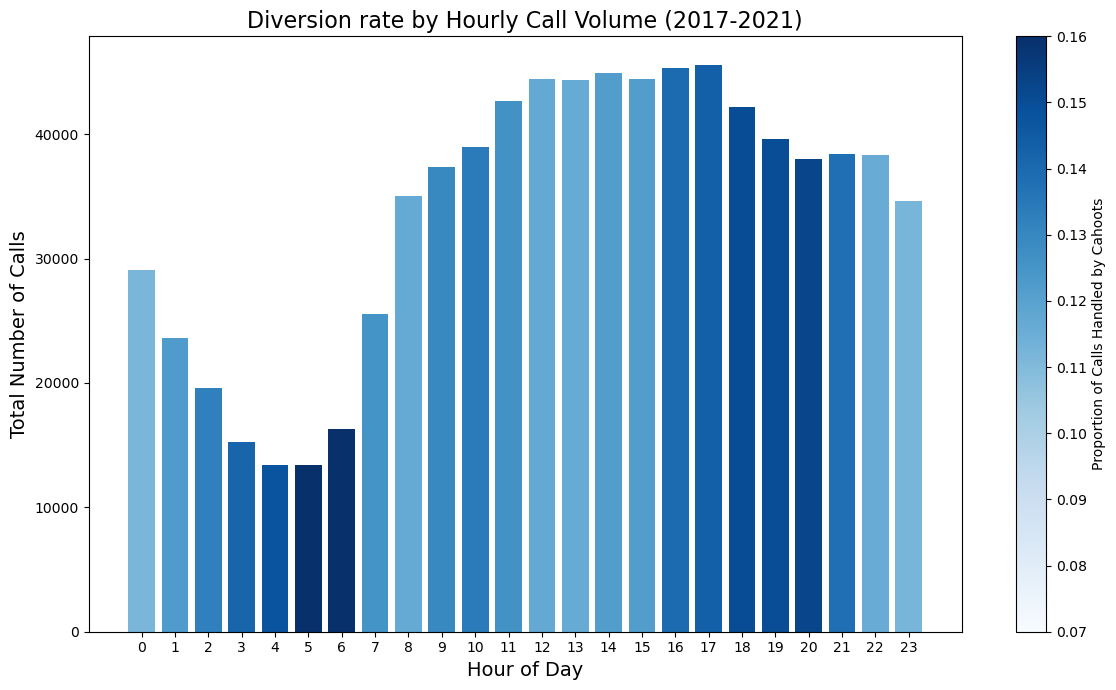

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the hour from 'Call_Created_Time'
CAD_data_filter = CAD_data_filter.copy()
CAD_data_filter['Hour'] = CAD_data_filter['Call_Created_Time'].dt.hour

# Calculate the number of calls handled by police and Cahoots by hour
call_volume_by_hour = CAD_data_filter.groupby(['Hour', 'Cahoots_related']).size().unstack(fill_value=0)
call_volume_by_hour.columns = ['Police', 'Cahoots']

# Calculate the proportions
call_volume_by_hour['Total'] = call_volume_by_hour.sum(axis=1)
call_volume_by_hour['Cahoots_Proportion'] = call_volume_by_hour['Cahoots'] / call_volume_by_hour['Total']
call_volume_by_hour['Police_Proportion'] = call_volume_by_hour['Police'] / call_volume_by_hour['Total']

# Plot
plt.figure(figsize=(12, 7))
norm = plt.Normalize(0.07, 0.16)
colors = plt.cm.Blues(norm(call_volume_by_hour['Cahoots_Proportion']))

bars = plt.bar(call_volume_by_hour.index, call_volume_by_hour['Total'], color=colors)

# Create a ScalarMappable 
sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
sm.set_array([])

ax = plt.gca()  
cbar = plt.colorbar(sm, ax=ax) 
cbar.set_label('Proportion of Calls Handled by Cahoots')

plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Total Number of Calls', fontsize=14)
plt.title('Diversion rate by Hourly Call Volume (2017-2021)', fontsize=16)
plt.xticks(range(0, 24))
plt.tight_layout()

Examining diversion rates by hour of the day reveals two distinct diversion hotspots.
From 0000 - 0600 we see a steady rise in diversion rates, peaking from 0500-0600 and then falling off quickly at 0700. 

Several factors could contribute to this trend:

* **The unhoused population:** Individuals experiencing homelessness may seek shelter or resources during these early morning hours as temperatures drop and other options become limited.
* **Late-night activity:** As the night progresses, concern may grow for individuals who are still out, particularly those who are vulnerable or alone, leading to increased calls for welfare checks.
* **Mental health distress:** Sleep deprivation and other factors can exacerbate mental health conditions, potentially leading to crises in the early morning hours when support systems may be less available.

The second spike in diversion rates occurs in the evening hours, 1600 - 2100. This could be attributed to several factors:

* **Substance abuse:** Calls related to substance abuse may increase during these hours due to increased alcohol consumption or drug use after work or during social gatherings. 
* **Mental health episodes:** Similar to the early morning hours, mental health crises may be more prevalent in the evening, as individuals may experience increased stress, isolation, or triggers after a long day.
* **Interpersonal conflicts:** Disputes between individuals, families, or neighbors may escalate during the evening hours when people are more likely to be at home and interacting with each other.

Increased Cahoots activity during these time periods makes sense as the factors mentioned above lead to increases in Cahoots centric call types.


### Part 3: Diversions of Overlapping Mandate

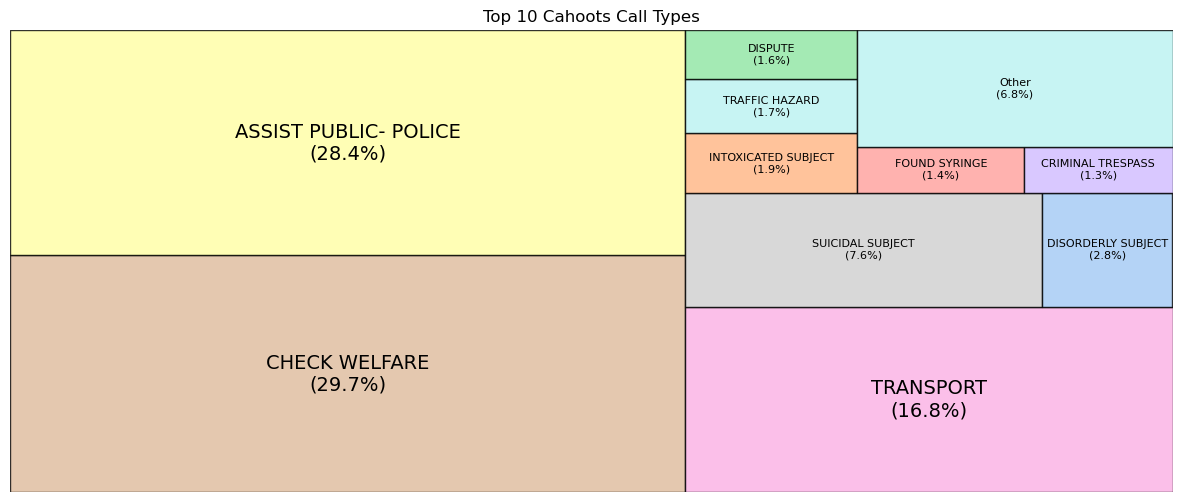

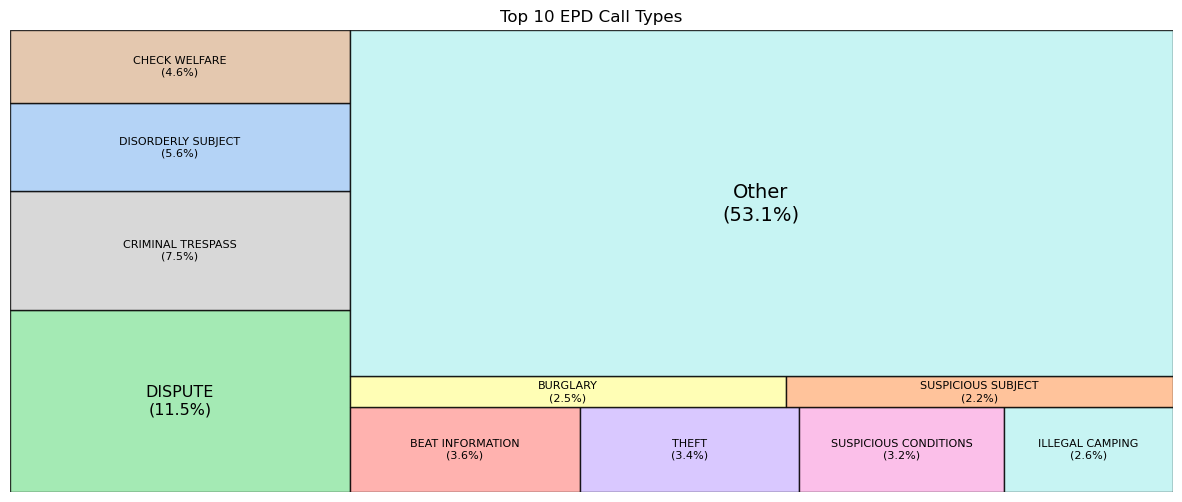

In [20]:
import matplotlib 
import matplotlib.cm as cm
from scripts.tree import create_treemap
import seaborn as sns

# use sns color palette
sns_colors = sns.color_palette("pastel")

# Use matplot colors
plt_colormap = matplotlib.colormaps['tab20b']
plt_colormap = [matplotlib.colors.rgb2hex(plt_colormap(i)) for i in range(plt_colormap.N)]

# Use custom colors
custom_colors = [
    '#009E73',  # Green
    '#E69F00',  # Gold/Orange
    '#56B4E9',  # Light Blue
    '#D55E00',  # Red-Orange/Brown
    '#CC79A7',  # Pink/Purple
    '#F0E442',  # Yellow (use sparingly)
    '#999999',  # Gray
    '#363737',  # Blackish
    '#FDB462',  # Light Orange
    '#B3DE69',  # Light Green
    '#BC80BD',  # Purple
    '#FB8072',  # Salmon
    '#1F78B4',  # Dark Blue
]

cahoots_data = CAD_data_filter[CAD_data_filter['Cahoots_related'] == 1]
police_data = CAD_data_filter[CAD_data_filter['Cahoots_related'] == 0]

create_treemap(cahoots_data, 'Top 10 Cahoots Call Types', top_n=10, group_others=True, max_legend_entries=10, show_labels=True, color_list=sns_colors, min_label_area_ratio=0.01)
create_treemap(police_data, 'Top 10 EPD Call Types', top_n=10, group_others=True, max_legend_entries=10, show_labels=True, color_list=sns_colors, min_label_area_ratio=0.012)

The stark contrast in the above call type distributions between the EPD and Cahoots, underscores the disparate range in their responsibilities. While Cahoots' top 10 call types account for most of their activity, the EPD's top 10 comprise less than half of their total call volume.

Having analyzed diversions based on Cahoots impact on EPD's total call volume, we now shift our focus to calls that could reasonably be handled by either Cahoots or the police. We begin by eliminating incident types with zero overlap, as these clearly fall outside Cahoots' purview.

However, determining substantial areas of overlap requires a more nuanced approach. We must consider both the total number of calls and the proportional overlap between agencies. For example, some incident types have been handled by both Cahoots and EPD 2 times. Perfect proportional overlap, but clearly not a significant area for either agency.

To strike a balance between raw call count and proportional overlap, we employ a composite scoring method that incorporates a log transformation to mitigate the impact of high call counts, followed by z-score normalization to ensure comparability across incident types. The goal is to identify incident types with a substantial presence for both Cahoots and the EPD, regardless of overall call volume. It is important to note that these diversion rates are not directly comparable to the ones seen in previous sections. We are using different data assumptions and measuring a different phenomenon. 

The full implementation can be found in `data_prep.ipynb`but here is a general breakdown of the steps we follow:

##### Calculate Proportions 

$$
\text{CahootsProportion}(i) = \frac{\log(\text{CahootsCalls}(i))}{\text{TotalCalls}(i)}
$$

$$
\text{PoliceProportion}(i) = \frac{\log(\text{PoliceCalls}(i))}{\text{TotalCalls}(i)}
$$

##### Calculate Harmonic Mean of the Proportions

$$
\text{HarmonicMeanProportion}(i) = \frac{2 \cdot (\text{CahootsProportion}(i) \cdot \text{PoliceProportion}(i))}{\text{CahootsProportion}(i) + \text{PoliceProportion}(i) + 1 \times 10^{-10}}
$$

#### Composite Score

$$
\text{CompositeScore}(i) = \text{HarmonicMeanProportion}(i) \cdot (\log(\text{CahootsCalls}(i)) + \log(\text{PoliceCalls}(i)))
$$

##### Z-score Normalization

$$
\text{NormalizedCompositeScores}(i) = \frac{\text{CompositeScore}(i) - \mu_{\text{CompositeScore}}}{\sigma_{\text{CompositeScore}}}
$$

##### Threshold for Substantial Incident Types

$$
\text{SubstantialIncidentTypes} = \{ i \ | \ \text{NormalizedCompositeScores}(i) > 0.3 \}
$$

In [21]:
overlap_diversions = pd.read_csv("Data/cleaned_data/cleaned_CAD_diversions.csv", parse_dates=['Call_Created_Time'])
overlap_diversions = overlap_diversions[(overlap_diversions["Call_Created_Time"].dt.year >= 2017) & (overlap_diversions["Call_Created_Time"].dt.year <= 2021)]
overlap_table = overlap_diversions["InitialIncidentTypeDescription"].value_counts().reset_index()
overlap_table

,InitialIncidentTypeDescription,count
0,CHECK WELFARE,57271
1,SUICIDAL SUBJECT,18300
2,TRAFFIC HAZARD,10645
3,CITIZEN CONTACT,4150
4,OVERDOSE,4031
5,ASSIST FIRE DEPARTMENT,3302
6,INTOXICATED SUBJECT,3271
7,DISORDERLY JUVENILES,3163
8,FOUND SYRINGE,1396
9,NUDE SUBJECT,1011


#### Incidents of Overlapping Mandate

Applying this methodology with a 1.5 cut off value yields 14 incidents deemed to have substantial enough overlap for our purposes. As the the original dataset includes over 150 call types, we have significantly narrowed our cross section of data. We can see that some incident types with high overlap and low total count are still included. However, even our lowest category still has 166 overall calls so our low end values seem to be relatively well controlled. 

Unsurprisingly, we see welfare checks at the top by a decent margin. As we saw in our natural experiment, welfare checks are the most significant overlapping call type. Public Assist and Transportation did not quite make the cut as they are majority Cahoots calls. Public Assist is right on the edge of inclusion, if the threshold were dropped to 1.4, it would be included. Since this category is only 22% divertible according to our natural experiment, the 1.5 threshold seems to better align with the goals of this calculation. 

There are some other notably missing call types that Cahoots sometimes handles such as criminal trespass. However, Cahoots only responds to 2% of this call type so the composite score was not high enough to make the cut. Overall, the categories selected through our composite scoring method seem to be accurately identifying areas of substantial overlap. 

One import caveat is that our algorithm assumes a call type to be either completely within the mandate of both agencies or exclusive to one agency. This is obviously not how things play out in the real world as we saw in our natural experiment. Future work could attempt to proportionally include call types based on estimated potential overlap. 

#### Diversions of Overlapping Mandate over Time

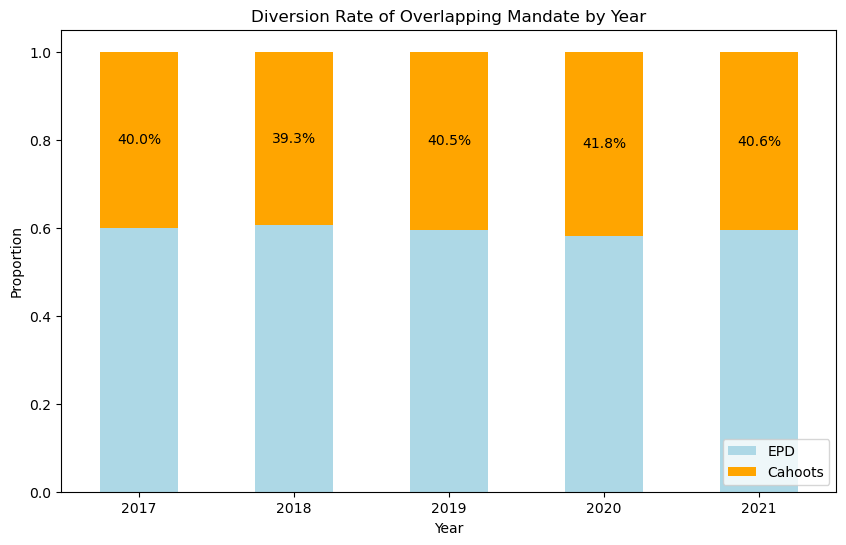

In [22]:
import matplotlib.pyplot as plt

CAD_data_diversions_filtered = overlap_diversions[
    overlap_diversions['Call_Created_Time'].dt.year.isin([2017, 2018, 2019, 2020, 2021])
]

# Group by year and whether it was Handled by Cahoots, then count occurrences
yearly_data_diversions = CAD_data_diversions_filtered.groupby(
    [CAD_data_diversions_filtered['Call_Created_Time'].dt.year, 'Cahoots_related']
).size().unstack(fill_value=0)

# Calculate proportions of calls handled by Cahoots vs Police by dividing by the row sum
yearly_data_prop_diversions = yearly_data_diversions.div(yearly_data_diversions.sum(axis=1), axis=0)

# Plotting
ax = yearly_data_prop_diversions.plot(kind='bar', stacked=True, color=['lightblue', 'orange'], figsize=(10, 6))

# Add labels to the bars
for i in range(yearly_data_prop_diversions.shape[0]):  
    cahoots_proportion = yearly_data_prop_diversions.iloc[i, 1]  # Proportion handled by Cahoots
    if cahoots_proportion > 0:  
        ax.text(i, yearly_data_prop_diversions.iloc[i, 0] + cahoots_proportion / 2,
                f'{cahoots_proportion:.1%}', ha='center', va='center', fontsize=10, color='black')

# Plot settings
plt.title('Diversion Rate of Overlapping Mandate by Year')
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(['EPD', 'Cahoots'], loc='lower right')

plt.show()

Focusing solely on our identified areas of overlapping mandate, the diversion rate ranges between 40% and 42%. The yearly trend loosley mirrors our previous findings, remaining relatively stable with an even slighter increase over time. 

This diversion rate also provides valuable insights into the scalability of the Cahoots model. By examining only the areas of overlapping mandate, we gauge how many calls Cahoots is diverting out of the total pool of potentially divertible calls. Given that Cahoots cannot respond to all call types, there's a theoretical maximum beyond which further diversion from the EPD becomes impossible.

Our results indicate that even with significant expansion, Cahoots is unlikely to exhaust the pool of divertible calls. This suggests that scaling up Cahoots' services would likely continue to yield substantial cost savings for traditional law enforcement.

#### Top 5 Incidents of Overlapping Mandate

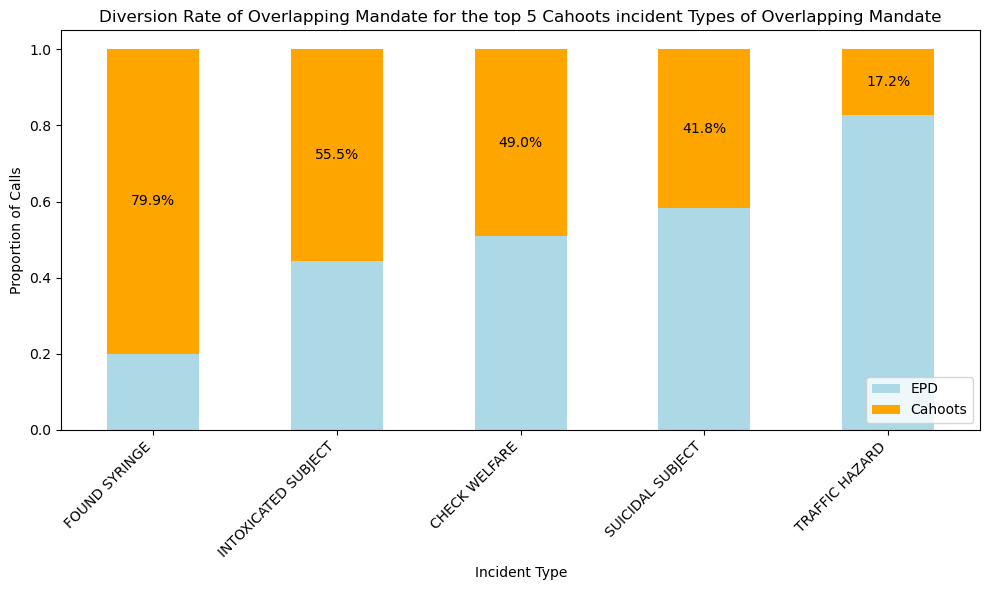

In [23]:
top_5_incidents = CAD_data_diversions_filtered[(CAD_data_diversions_filtered["PrimaryUnitCallSign"] == "CAHOOT") & (CAD_data_diversions_filtered["IsPrimary"] == 1)]["InitialIncidentTypeDescription"].value_counts().nlargest(5).index


CAD_data_diversions_filtered_top_5 = CAD_data_diversions_filtered[CAD_data_diversions_filtered["InitialIncidentTypeDescription"].isin(top_5_incidents)]

incident_data = CAD_data_diversions_filtered_top_5.groupby(['InitialIncidentTypeDescription', 'Cahoots_related']).size().unstack(fill_value=0)
incident_data_prop = incident_data.div(incident_data.sum(axis=1), axis=0)

incident_data_sorted = incident_data_prop.sort_values(by=1, ascending=False)
ax = incident_data_sorted.plot(kind='bar', stacked=True, color=['lightblue', 'orange'], figsize=(10, 6))

# Add labels to the Cahoots portion of the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if p.get_facecolor() == ax.patches[-1].get_facecolor() and height > 0: 
        ax.text(x + width / 2, y + height / 2, f'{height:.1%}', ha='center', va='center', fontsize=10)

plt.title('Diversion Rate of Overlapping Mandate for the top 5 Cahoots incident Types of Overlapping Mandate')
plt.xlabel('Incident Type')
plt.ylabel('Proportion of Calls')
plt.xticks(rotation=45, ha='right')
plt.legend(['EPD', 'Cahoots'], loc='lower right')
plt.tight_layout()
plt.show()

Analyzing the diversion rate for each call type within the Overlapping Mandate reveals varying degrees of potential for Cahoots expansion. Notably, Cahoots already handles 80% of "Found Syringe" calls, suggesting limited room for further growth in this area.

It's crucial to acknowledge that Cahoots may not be eligible for dispatch to every call within the Overlapping Mandate, and some calls might not even exist without Cahoots' presence. While the divertibility measures from our natural experiment offer insight into calls potentially created by Cahoots, they don't reveal the proportion of each call type that Cahoots is authorized to handle.

Unfortunately, I have yet to determine a reliable proxy for this. Future research should prioritize developing a method to quantify the proportion of each call type eligible for Cahoots intervention. 

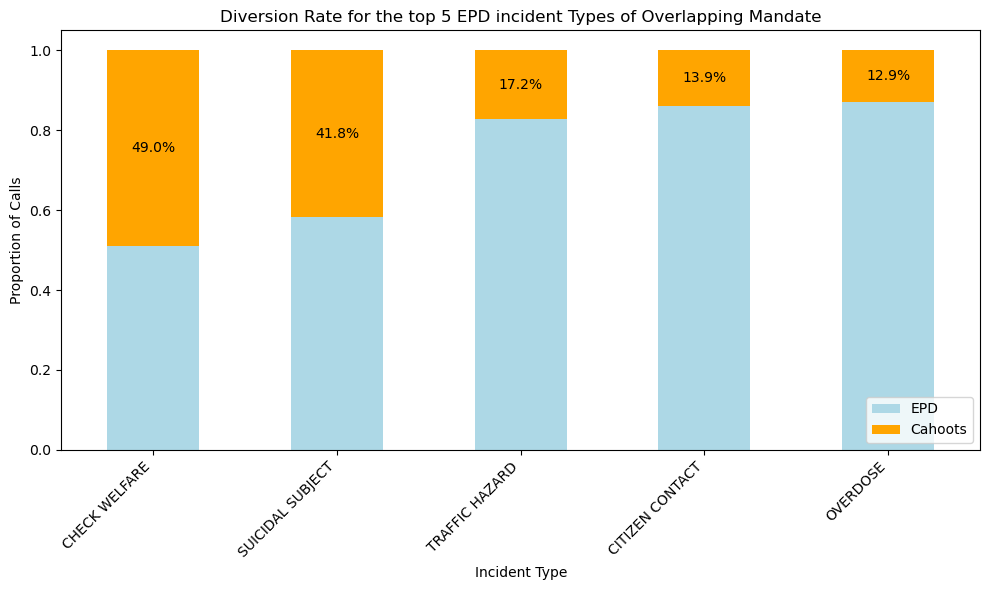

In [24]:
top_5_incidents = CAD_data_diversions_filtered[CAD_data_diversions_filtered["Cahoots_related"] == 0]["InitialIncidentTypeDescription"].value_counts().nlargest(5).index


CAD_data_diversions_filtered_top_5 = CAD_data_diversions_filtered[CAD_data_diversions_filtered["InitialIncidentTypeDescription"].isin(top_5_incidents)]

incident_data = CAD_data_diversions_filtered_top_5.groupby(['InitialIncidentTypeDescription', 'Cahoots_related']).size().unstack(fill_value=0)
incident_data_prop = incident_data.div(incident_data.sum(axis=1), axis=0)

incident_data_sorted = incident_data_prop.sort_values(by=1, ascending=False)
ax = incident_data_sorted.plot(kind='bar', stacked=True, color=['lightblue', 'orange'], figsize=(10, 6))

# Add labels to the Cahoots portion of the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if p.get_facecolor() == ax.patches[-1].get_facecolor() and height > 0: 
        ax.text(x + width / 2, y + height / 2, f'{height:.1%}', ha='center', va='center', fontsize=10)

plt.title('Diversion Rate for the top 5 EPD incident Types of Overlapping Mandate')
plt.xlabel('Incident Type')
plt.ylabel('Proportion of Calls')
plt.xticks(rotation=45, ha='right')
plt.legend(['EPD', 'Cahoots'], loc='lower right')
plt.tight_layout()
plt.show()

Looking at the top EPD call types within the overlapping mandate reveals a similar pattern of potential Cahoots expansion opportunities. Welfare checks, traffic hazards, and suicidal subjects appear again, alongside overdose and citizen contact calls. These categories represent significant areas for potential Cahoots intervention, but definitive recommendations remain out of reach without a way to confirm if a call is truly Cahoots eligible.

While our analysis highlights promising avenues for expanding Cahoots' role, it's crucial to acknowledge the limitations of the available data.  Without a clear understanding of which calls are within Cahoots' dispatch criteria, we cannot definitively recommend shifting specific call types more into their jurisdiction.  Further research and collaboration with the EPD are needed to define clear eligibility criteria for Cahoots and accurately assess the full potential for expansion.

## Discussion

Our analysis reveals a considerably higher potential for call diversion to Cahoots than the EPD's report indicated. Methodological inconsistencies in the EPD's assessment, including unclear definitions and selective data use, led to an underestimation of the diversion rate, which we place between 8% and 15%. However, our findings also confirm the EPD's assertion that the previously suggested 17-20% diversion rate is likely an overestimation, as not all Cahoots calls would necessarily fall under the EPD's responsibility.

A closer examination of the "overlapping mandate"—call types that both organizations can handle—shows a diversion rate of 40-42%, highlighting Cahoots' current effectiveness and suggesting potential for further expansion. However, this figure is not directly comparable to the EPD's overall diversion rate and requires further refinement.

Ultimately, our research offers a more comprehensive and accurate understanding of call diversion, challenging the validity of the EPD's initial analysis. This approach provides a stronger foundation for future discussions and policy decisions regarding alternative response models like Cahoots. 

## Sources

**Media Reports of 17-20% Diversion Rate** (1)

https://www.usnews.com/news/cities/articles/2020-07-06/eugene-oregons-30-year-experiment-with-reimagining-public-safety

https://whitebirdclinic.org/wp-content/uploads/2020/06/CAHOOTS-Media-Guide-20200626.pdf


**EPD 2021 Response Paper** (2)

https://www.eugene-or.gov/DocumentCenter/View/66051/CAHOOTS-program-analysis-2021-update

**Github:** https://github.com/Nathan-M-Burton/Cahoots-Impact-Assessment (3)

**Service Hours Expansion** (4)

https://kval.com/news/local/cahoots-starts-24-hour-eugene-service-in-january-2017

**All Scripts:** `police_diversion_methodology.py`, `tree.py`, `natural_exp.py` 

**Notebooks:** `data_prep.ipynb`, `analysis.ipynb`